In [1]:
import torch
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

# Dataset

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
ID: 0, Label: bottle
ID: 1, Label: metal
ID: 2, Label: glass
ID: 3, Label: paper
ID: 4, Label: cardboard
5


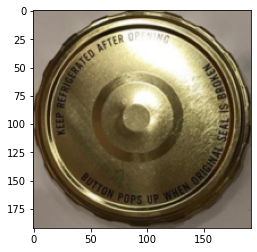

In [3]:
import numpy as np
import torch.utils.data as data
from pycocotools.coco import COCO
import os

from PIL import Image
from torchvision.transforms import functional as F


class MyCOCODataset(data.Dataset):
    def __init__(self, data_root, annofile, output_size=(192, 192)):
        self.data_root = data_root
        self.annofile = annofile
        self.coco = COCO(annofile)
        self.instance_ids = list(self.coco.anns.keys())
        self.instances = self.coco.anns
        self.output_size = output_size

    def __getitem__(self, index):
        id = self.instance_ids[index]
        ann = self.instances[id]
        imgid = ann["image_id"]
        # [x, y , w, h]
        bbox = ann["bbox"]
        img_file = self.coco.loadImgs([imgid])[0]["file_name"]
        img = Image.open(os.path.join(self.data_root, img_file))

        # cutout the instance from bbox
        _bbox_int = list(map(int, bbox))
        img = img.crop(
            (
                _bbox_int[0],  # x1
                _bbox_int[1],  # y1
                _bbox_int[0] + _bbox_int[2],  # x2 = x1 + w
                _bbox_int[1] + _bbox_int[3],  # y2 = y1 + h
            )
        )
        # resize the iamge to corresponding size
        img = img.resize(self.output_size, Image.BILINEAR)
        if img.mode == "L":
            img = img.convert("RGB")

        # convert image to tensor
        img = np.array(img)

        # handle the annotation
        category = ann["category_id"]
        category = np.array(category, dtype=np.int64)

        assert img.shape[0] == self.output_size[0]
        assert img.shape[1] == self.output_size[1]
        assert img.shape[2] == 3

        return img, category

    def __len__(self):
        return len(self.instance_ids)

    # utility function to print all categories
    def print_all_categories(self):
        for id, category in self.coco.cats.items():
            print(f'ID: {id}, Label: {category["name"]}')

### START CODE HERE ### (≈ 1 line of code) 
# Complete the loading of the data set: 
# e.g., dataset = MyCOCODataset(Path = '',Json = '')

# dataset = MyCOCODataset(
#     "data/data_coco",
#     "data/data_coco/annotations.json",
# )

### END CODE HERE ###
dataset.print_all_categories()
print(len(dataset))
img, label = dataset[0]
plt.imshow(img)

# Model (Here you can change the deep learning model)

In [ ]:
from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()

        # NOTE: visual backbone

        ### START CODE HERE ### (≈ 1 line of code) 
        # you need to Build AlexNet network
        # e.g., self.features = nn.Sequential(,,,,,)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        ### END CODE HERE ###

        # [batch, 256, 6,6]
        # NOTE: header, stduent filling
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        ### START CODE HERE ### (≈ 1 line of code) 
        # you need to Build classifier layer
        # e.g., self.classifier = nn.Sequential(,,,,,)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        ### END CODE HERE ###

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# test code
model = AlexNet(num_classes=1000)
x = torch.randn(1, 3, 192, 192)
print(model(x).shape)


torch.Size([1, 1000])


# Trainining

In [7]:
lr = 1e-3
device = "cpu"
batch_size = 32
num_classes = 7
num_epoch = 10

model = AlexNet(num_classes=num_classes).to(device)

tran_set = MyCOCODataset(
    "data/data_coco",
    "data/data_coco/annotations.json",
)
val_set = MyCOCODataset(
    "data/data_coco",
    "data/data_coco/annotations.json",
)

trainloader, val_loader = (
    DataLoader(tran_set, batch_size=batch_size, shuffle=True),
    DataLoader(val_set, batch_size=batch_size, shuffle=True),
)




loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # trainning loop
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # NOTE: the input data should be normalized to [0, 1]
        # or to distribution with mean 0 and std 1
        images = images.float() / 255.0

        # NOTE: the input shape for Pytorch should be [batch_size, channels, height, width]
        # so we need to transpose the input data
        images = images.permute(0, 3, 1, 2)

        images, labels = images.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f"a batch done, batch id: {i} loss: {loss.item()}")

    # validation loop
    best_accuracy = 0
    validate_predicte = []
    validate_ground_truth = []
    with torch.no_grad():
        for data in val_loader:
            images, labels = data

            # data preprocessing
            images = images.float() / 255.0
            images = images.permute(0, 3, 1, 2)

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            validate_predicte.append(predictions.detach())
            validate_ground_truth.append(labels.detach())

    # calulate the accuracy
    validate_predicte = torch.cat(validate_predicte)
    validate_ground_truth = torch.cat(validate_ground_truth)
    correct = (validate_predicte == validate_ground_truth).sum().item()
    accuracy = correct / len(validate_ground_truth)

    # save checkpoint if the accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "outputs/best_model.pth")

    print(f"epoch: {epoch} accuracy: {accuracy}")

a batch done, batch id: 0 loss: 1.9447205066680908
epoch: 0 accuracy: 0.4
a batch done, batch id: 0 loss: 1.5598405599594116
epoch: 1 accuracy: 0.2
a batch done, batch id: 0 loss: 11.802762985229492
epoch: 2 accuracy: 0.4
a batch done, batch id: 0 loss: 5.101893424987793
epoch: 3 accuracy: 0.2
a batch done, batch id: 0 loss: 1.898449182510376
epoch: 4 accuracy: 0.2
a batch done, batch id: 0 loss: 1.8510046005249023
epoch: 5 accuracy: 0.2
a batch done, batch id: 0 loss: 1.8457202911376953
epoch: 6 accuracy: 0.2
a batch done, batch id: 0 loss: 1.8534685373306274
epoch: 7 accuracy: 0.4
a batch done, batch id: 0 loss: 1.8712539672851562
epoch: 8 accuracy: 0.0
a batch done, batch id: 0 loss: 1.8166053295135498
epoch: 9 accuracy: 0.2


# Evaluation (you can also change the confusion matrix colors and also add F1 score matrics)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Accuracy: 1.0
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])


C:\Users\Wayen\AppData\Local\Temp\ipykernel_15900\124521563.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


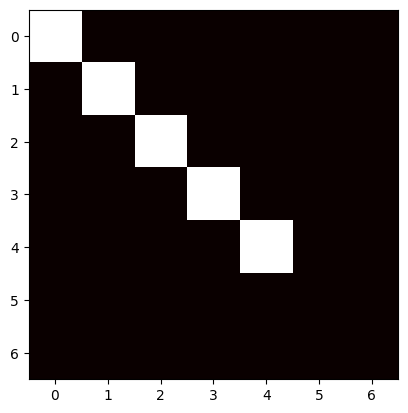

In [ ]:
classes = 7
checkpoint_path = "outputs/best_model.pth"
device = "cpu"

def confusion_matrix(predicted, ground_truth, num_classes):
    matrix = torch.zeros(num_classes, num_classes)
    for p, g in torch.stack([predicted, ground_truth], dim=1):
        matrix[p, g] += 1
    return matrix


# reconstruct the model
model = AlexNet(num_classes=classes).to(device)
# read paramerers
ckpt = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(ckpt)

# load test dataaset, similar as the training
test_set = MyCOCODataset(
    "data/data_coco",
    "data/data_coco/annotations.json",
)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

test_predicte = []
test_ground_truth = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        # data preprocessing
        images = images.float() / 255.0
        images = images.permute(0, 3, 1, 2)

        # move device
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        test_predicte.append(predictions.detach())
        test_ground_truth.append(labels.detach())

# calulate the accuracy
test_predicte = torch.cat(test_predicte)
test_ground_truth = torch.cat(test_ground_truth)
correct = (test_predicte == test_ground_truth).sum().item()
accuracy = correct / len(test_ground_truth)
print(f"Accuracy: {accuracy}")

# NOTE: draw confusion matrix
matrix = confusion_matrix(test_predicte, test_ground_truth, classes)
print(matrix)

# NOTE: draw confusion matrix
plt.imshow(matrix, cmap="hot", interpolation="nearest")